In [71]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [72]:
data1 = pd.read_csv('data/datatest.txt')
data2 = pd.read_csv('data/datatraining.txt')
data3 = pd.read_csv('data/datatest2.txt')

In [73]:
# data.iloc[0] represent the first example on the dataset
# data.iloc[0].date get the date from the first example

# data.iloc[-1] represent the last example on the dataset
# data.iloc[0].date get the date from the last example

print("data1 is from ", data1.iloc[0].date, " to ", data1.iloc[-1].date)
print("data2 is from ", data2.iloc[0].date, " to ", data2.iloc[-1].date)
print("data3 is from ", data3.iloc[0].date, " to ", data3.iloc[-1].date)


data1 is from  2015-02-02 14:19:00  to  2015-02-04 10:43:00
data2 is from  2015-02-04 17:51:00  to  2015-02-10 09:33:00
data3 is from  2015-02-11 14:48:00  to  2015-02-18 09:19:00


Just contact of all the separated dataframe (data1, data2 and data3) on a single dataframe

In [74]:
data_all = pd.concat([data1, data2, data3])
print("data_all is from ", data_all.iloc[0].date, " to ", data_all.iloc[-1].date)

data_all is from  2015-02-02 14:19:00  to  2015-02-18 09:19:00


In [75]:
# trasformo in datetime l'elemento 'date'
data_all['date'] = pd.to_datetime((data_all['date']))

# creo delle colonne utili, inizializzandole tutte e zero (float)
data_all['Notte'] = 0.
data_all['Mattina'] = 0.
data_all['Mezzogiorno'] = 0.
data_all['Pomeriggio'] = 0.
data_all['Sera'] = 0.

# assegno i valori alle colonne create sopra sulla base della fascia oraria
data_all.loc[(data_all['date'].dt.hour < 8) | (data_all['date'].dt.hour > 21), 'Notte'] = 1.
data_all.loc[(data_all['date'].dt.hour <= 12) & (data_all['date'].dt.hour >= 8), 'Mattina'] = 1.
data_all.loc[(data_all['date'].dt.hour > 12) & (data_all['date'].dt.hour <= 15), 'Mezzogiorno'] = 1.
data_all.loc[(data_all['date'].dt.hour > 15) & (data_all['date'].dt.hour <= 18), 'Pomeriggio'] = 1.
data_all.loc[(data_all['date'].dt.hour > 18) & (data_all['date'].dt.hour <= 21), 'Sera'] = 1.

# elimino eventuali duplicati
data_all.drop_duplicates(inplace=True)

# rinomino Occupancy ad Occupato
data_all['Occupato'] = data_all['Occupancy']
del data_all['Occupancy']

# setto 'date' come inide
data_all.set_index('date', inplace=True)

data_all.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Notte,Mattina,Mezzogiorno,Pomeriggio,Sera,Occupato
date,,,,,,,,,,,
2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,0.0,0.0,1.0,0.0,0.0,1
2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,0.0,0.0,1.0,0.0,0.0,1


In [76]:
print(type(data_all))

# creo un oggeto np array associato al dataset
dataset = data_all.values

print(type(dataset))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


In [77]:
# Divido train e plit test

split_point = int(len(dataset) * 0.95)

x_train = dataset[:split_point, :-1 ]
y_train = dataset[:split_point, -1 ]

x_test = dataset[split_point:, :-1 ]
y_test = dataset[split_point:, -1 ]

In [78]:
# Normalizzo i dati

scaler = StandardScaler()
scaler.fit(x_train)

x_train_std = scaler.transform(x_train)
x_test_std = scaler.transform(x_test)

In [79]:
print("dataset originale:", x_train_std.shape)
print(x_test_std.shape)

dataset originale: (19532, 10)
(1028, 10)


get_time_series(...) si occupa di trasformare il dataset originale in una __serie temporale__ che potrà poi essere data in pasto alla nostra rete ricorrente

**supponiamo che**
- steps_back = 3
- len(features) = 100

avremo *i* che va *da 3 a 100*, **da cui**

**i = 3 (prima)**\
ts_features.append( features[0 : 3] ) _<- da 0 a 2 compresi_ \
ts_labels.append(labels[2]) _<- label elemento 2_

x = [0,1,2] \
y = [y(2)]

--
  
**i = 4**\
ts_features.append( features[1 : 4] ) _<- da 1 a 3 compresi_ \
ts_labels.append(labels[3]) _<- label elemento 3_


x = [1,2,3] \
y = [y(3)]

--

[...]

--

**i = 99  (penultima)**\
ts_features.append( features[96 : 99] ) _<- da 96 a 98 compresi_ \
ts_labels.append(labels[98]) _<- label elemento 98_

x = [96,97,98] \
y = [y(98)]

--

**i = 100  (ultima)**\
ts_features.append( features[96 : 99] ) _<- da 96 a 98 compresi_ \
ts_labels.append(labels[99]) _<- label elemento 99_

x = [97,98,99] \
y = [y(99)]

--

in pratica ts_features è una serie temporale di 97 elementi, ognuno dei quali contiene 3 sequenze diverse e, per ognuna di queste segnenze, contiene le varie features

In [80]:
def get_time_series(features, labels, steps_back):
    
    assert len(features) == len(labels)
    assert steps_back > 0
    
    ts_features = []
    ts_labels = []
    
    for i in range(steps_back, len(features) +1):
        ts_features.append( features[i - steps_back : i] )
        ts_labels.append(labels[i - 1])
    
    return np.asarray(ts_features), np.asarray(ts_labels)

steps_back = 60

#Trasformo i dataset di train e i dataset di test in serie temporali
x_train_ts, y_train_ts = get_time_series(x_train_std, y_train, steps_back)
x_test_ts, y_test_ts = get_time_series(x_test_std, y_test, steps_back)

len(RECURRENT) = len(ORIGINALE) - T + 1

In [81]:
print(x_train_ts.shape)
print(y_train_ts.shape)

(19473, 60, 10)
(19473,)


Vari controlli che sia tutto ok

In [82]:
# Verico che la singola serie temporale abbia gli stessi valore
# dei valori contenuti nel rispettivo elemento del dataset originale
# guardo la prima
assert np.all(x_train_ts[0][0] == x_train_std[0])

# Verifico che l'etichetta della prima serie temporale sia corretta
# (guardo per la prima)
assert y_train_ts[0] == y_train[steps_back]

# Stessa identica cosa su un elemento a caso (42)
assert np.all(x_train_ts[42][0] == x_train_std[42])
assert y_train_ts[42] == y_train[42 + steps_back]



# Rifaccio gli stessi controlli di cui sora, anche per la serie di test
assert np.all(x_test_ts[0][0] == x_test_std[0])
assert y_test_ts[0] == y_test[steps_back]

assert np.all(x_test_ts[42][0] == x_test_std[42])
assert y_test_ts[42] == y_test[42 + steps_back]

Utilizziamo una rete di default di Keras (SimpleRNN)

Creo la rete in maniera funzionale, utilizzando la SimpleRNN 

**Studio dimensionale parametri del modello**

\

**|| W(input) || = n° features x n° celle**

Questo è il calcolo di base delle reti neurali. Ogni input (feauture in questo caso) si connette in modo dense a ogni cella del layer, creando un numero di parametri pari a n° features x n° celle

\

**|| W(ricorrente) || = n° celle x n° celle**

Nelle reti ricorrenti abbiamo che la nuova funzione di attivazione sarà:
\
g( W(input).T \*x + W(ricorrente) \* h[t-1] + b )

\


quindi W(ricorrente) \* h[t-1] deve potersi sommare (e quindi avere la stessa dimensione di W(input).T \*x.

\

**Sappiamo che**
\
\
|| W(input) || = n° features x n° celle 
\
\
**da cui** 
\
\
||W(input).T||  = n° celle  x n° features
\
\
**mentre** 
\
\
|| x || =  n° features x 1
\
\
**da cui abbiamo che** 
\
 W(input).T \* x  = ( n° celle x n° features ) x ( n° features x 1 ) = n° celle x 1

**quindi** per poter fare la somma **vogliamo che:**

> W(ricorrente) \* h[t-1] = n° celle x 1

**e sappiamo anche che**
\
\
 || h[t-1] || = (n° celle x 1 )
\
\
**da cui**
(? x ? ) \* (n° celle x 1 ) =  n° celle x 1 
\
\
**e quindi infine**
\
\
(? x ? ) = ( n° celle x n° celle)
\
\
**infatti**
( n° celle x n° celle) x  (n° celle x 1 ) = (n° celle x 1)
\
\
**Inoltre sappiamo anche che**

 || b || = n° celle x 1


e questo tornerà nuovamente in input al nodo h.


Paramentei totali = ||W(input)|| + ||W(ricorrente)|| + ||b||


\
W(input)      = n° features x n° celle
\
W(ricorrente) = n° celle x n° celle
\
b = n° celle x 1          
\
\
**nel nostro caso:**
- W(input)      = 10 x 4
- W(ricorrente) = 4 x 4
- b             = 4

\
**Totale**        = 40 + 16 + 4 = 60

\
A cui si sommano i 5 parametri della dense con un solo nodo (4 coefficienti + 1 bias)
\
\
**Totale**        =  60+ 5 = 65

In [83]:
# Definisco l'on input
# con x_train_ts.shape[1:] escludo la prima dimensione perché mi 
# va a rappresentare il numero di esempi del dataset (19472), ma noi
# vogliamo solamente la shape  (60,10)
input = tf.keras.layers.Input(shape=x_train_ts.shape[1:])

# Definisco la RNN associata all'input
rnn = tf.keras.layers.SimpleRNN(units=4, dropout=0.5)(input)

# Definisco l'output
output = tf.keras.layers.Dense(1, activation='sigmoid')(rnn)

## ACHTUNG
# Per fare un test ho cambiato l'outpu con rnn

# creo il modello
model = tf.keras.models.Model(
    inputs=input,
    outputs=output,
)

# 'compilo' il modello
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.BinaryAccuracy()
)

model.summary()



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 60, 10)]          0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 4)                 60        
                                                                 
 dense_1 (Dense)             (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(
    x_train_ts,
    y_train_ts,
    batch_size=256,
    epochs=10,
    validation_data=(
        x_test_ts,
        y_test_ts
    ),
    verbose=2
)

Epoch 1/10
77/77 - 5s - loss: 0.2225 - binary_accuracy: 0.6449 - val_loss: 0.3172 - val_binary_accuracy: 0.1981 - 5s/epoch - 61ms/step
Epoch 2/10
77/77 - 2s - loss: 0.1111 - binary_accuracy: 0.8633 - val_loss: 0.4056 - val_binary_accuracy: 0.2043 - 2s/epoch - 23ms/step
Epoch 3/10
77/77 - 1s - loss: 0.0673 - binary_accuracy: 0.9191 - val_loss: 0.6359 - val_binary_accuracy: 0.0774 - 1s/epoch - 17ms/step
Epoch 4/10
77/77 - 1s - loss: 0.0406 - binary_accuracy: 0.9570 - val_loss: 0.5446 - val_binary_accuracy: 0.3199 - 715ms/epoch - 9ms/step
Epoch 5/10
77/77 - 1s - loss: 0.0274 - binary_accuracy: 0.9719 - val_loss: 0.0641 - val_binary_accuracy: 0.9267 - 731ms/epoch - 9ms/step
Epoch 6/10
77/77 - 2s - loss: 0.0228 - binary_accuracy: 0.9758 - val_loss: 0.1273 - val_binary_accuracy: 0.8555 - 2s/epoch - 22ms/step
Epoch 7/10
77/77 - 1s - loss: 0.0202 - binary_accuracy: 0.9779 - val_loss: 0.0638 - val_binary_accuracy: 0.9278 - 1s/epoch - 19ms/step
Epoch 8/10
77/77 - 1s - loss: 0.0209 - binary_accur

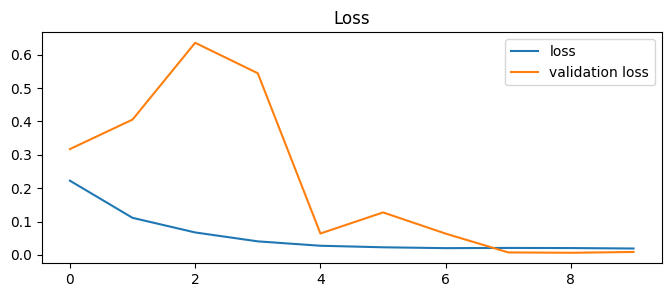

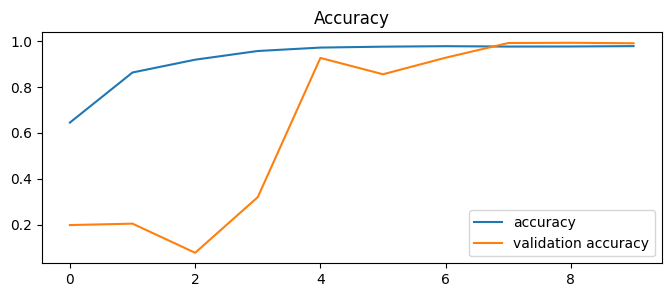

In [85]:
plt.figure(figsize=(8,3))
plt.title('Loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

plt.figure(figsize=(8,3))
plt.title('Accuracy')
plt.plot(history.history['binary_accuracy'], label='accuracy')
plt.plot(history.history['val_binary_accuracy'], label='validation accuracy')
plt.legend()
plt.show()

In [86]:
print( f" Prediction: {model.predict(x_test_ts[42:43])} \n Real: {y_test_ts[42]}" )

1/1 [==============================] - 0s 157ms/step
 Prediction: [[0.9725261]] 
 Real: 1.0


In [87]:
print( f" Prediction: {model.predict(x_test_ts[114:115])} \n Real: {y_test_ts[114]}" )

1/1 [==============================] - 0s 23ms/step
 Prediction: [[0.02431748]] 
 Real: 0.0


In [88]:
preds = model.predict(x_test_ts)
preds = preds[:, 0]
preds[preds > 0.5] = 1
preds[preds < 1] = 0

print(accuracy_score(y_test_ts, preds))

31/31 [==============================] - 0s 2ms/step
0.9907120743034056
